In [7]:
import sys
sys.path.append("../")
from src import Estrategia, agrega_estrategias
import sqlite3
import pandas as pd

#Cargar base de días hábiles
dbpath = r'../data_auxiliar/db_habiles.db'
conn_habiles = sqlite3.connect(dbpath)
df_dias_habiles = pd.read_sql('SELECT * FROM HABILES',
                         conn_habiles, parse_dates=['Fecha'])

# PARAMETROS PARA DEFINIR LA ESTRATEGIA
#fecha_ini = datetime.datetime.strptime('2014-01-01', '%Y-%m-%d').date()
fecha_ini = pd.to_datetime('2014-01-01')
fecha_end = pd.to_datetime('2020-11-23')

afp = 'HABITAT'
monto_inicial = 100
lag_solicitud = 0

In [71]:
estrategia_a = Estrategia(fecha_ini, fecha_end, 'A')
estrategia_e = Estrategia(fecha_ini, fecha_end, 'E')
estrategia_ff = Estrategia(fecha_ini, fecha_end, 'FF',
                           '../2_avisos_cambio_fondos/anuncios_ff.xlsx')

lista_estrategias = [estrategia_a, estrategia_e, estrategia_ff]

df = agrega_estrategias(lista_estrategias, df_dias_habiles,
                        afp, monto_inicial, lag_solicitud)
df.head(5)

,Fecha,Val_A_lag_0,Val_E_lag_0,Val_FF_lag_0
0,2014-01-01,100.000000,100.000000,100.000000
1,2014-01-02,100.336932,100.033161,100.336932
2,2014-01-03,100.253135,100.009698,100.253135
3,2014-01-04,100.253135,100.009698,100.253135
4,2014-01-05,100.253135,100.009698,100.253135


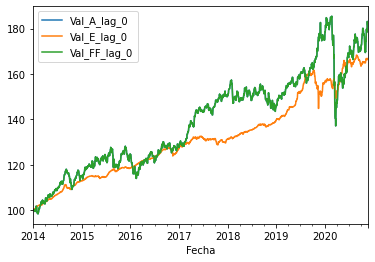

In [10]:
df.set_index('Fecha').plot()

### 2. Comparemos la estrategia FF versus fondo A y fondo E, con LAG = 2

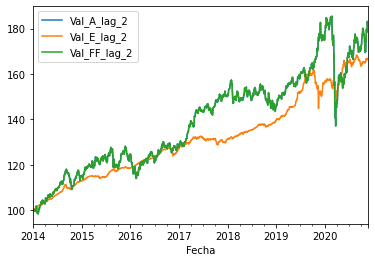

In [13]:
df = agrega_estrategias(lista_estrategias, df_dias_habiles, 
                        afp, monto_inicial, lag_solicitud=2)
df.set_index('Fecha').plot()

### 3. Comparemos fondo A versus estrategia FF con 0 y 2 dias de LAG 

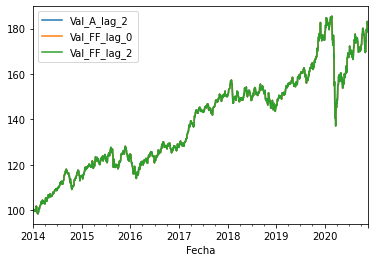

In [16]:
lista_estrategias = [estrategia_a, estrategia_ff, estrategia_ff]

df = agrega_estrategias(lista_estrategias, df_dias_habiles,
                        afp, monto_inicial, [2, 0, 2])
df.set_index('Fecha').plot()

### 4. Comparemos fondo A versus estrategia FF verus estrategia "MAX"

**HIPOTESIS:** Si alguien tiene la capacidad para "predecir" al mercado, su curva de rendimientos debería estar entre la curva pasiva y la curva de mejores rendimientos (Estrategia "MAX").

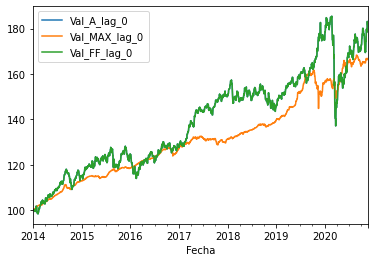

In [19]:
estrategia_max = Estrategia(fecha_ini, fecha_end, 'MAX',
                            '../2_avisos_cambio_fondos/optima_HABITAT.xlsx')

lista_estrategias = [estrategia_a, estrategia_max, estrategia_ff]

df = agrega_estrategias(lista_estrategias, df_dias_habiles, afp, monto_inicial, 0)
df.set_index('Fecha').plot()

### 5. ¿Cómo le va a una estrategia en diferentes horizontes de tiempo?

+ Por ejemplo, supongamos que me quiero jubilar en 3 años.
+ Hay diferentes resultados dependiendo del punto de partida. [t, t+ 3 años], [t + x, t + x + 3 años]. Llamemos `offset` a ese `x`
+ Dado un horizonte de tiempo, podemos construir una distribución de resultados para cada `offset` x.

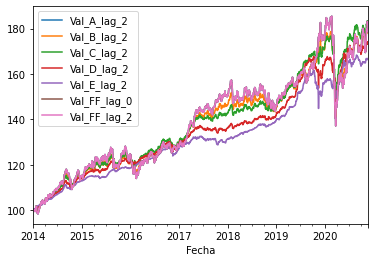

In [21]:
estrategias_afp = [Estrategia(fecha_ini, fecha_end, fondo) for fondo in ['A', 'B', 'C', 'D', 'E']]

lista_estrategias = estrategias_afp + [estrategia_ff, estrategia_ff]

df = agrega_estrategias(lista_estrategias, df_dias_habiles,
                        afp, monto_inicial, [2, 2, 2, 2, 2, 0, 2])
df.set_index('Fecha').plot()

In [38]:
horizonte_de_tiempo = pd.Timedelta(3*365, unit="d")
beg_period = df.Fecha.min()
end_period = df.Fecha.max() - horizonte_de_tiempo

all_starting_days_of_experiment = pd.date_range(beg_period, end_period, freq='d')

In [62]:
relevant_columns = [col for col in df.columns if col != 'Fecha']

rows = []
for start_date in all_starting_days_of_experiment:
    start_data = df.loc[df.Fecha == start_date, relevant_columns]
    end_data = df.loc[df.Fecha == start_date + horizonte_de_tiempo, relevant_columns]
    rows.append(pd.DataFrame(100* (end_data.values / start_data.values - 1), columns=relevant_columns,
                      index=[start_date]))

In [65]:
results = pd.concat(rows)
results.head(3)

,Val_A_lag_2,Val_B_lag_2,Val_C_lag_2,Val_D_lag_2,Val_E_lag_2,Val_FF_lag_0,Val_FF_lag_2
2014-01-01,27.669397,28.042024,29.785580,29.197199,27.169933,27.669397,27.669397
2014-01-02,27.240683,27.749932,29.577455,29.087130,27.127777,27.240683,27.240683
2014-01-03,27.347037,27.771380,29.541241,29.105020,27.157602,27.347037,27.347037


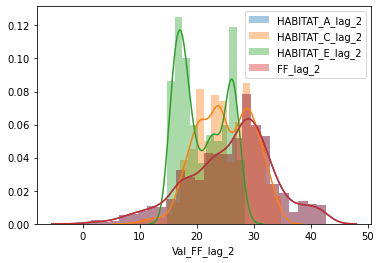

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

sns.distplot(results.Val_A_lag_2, ax=ax, label=f"{afp}_A_lag_2")
sns.distplot(results.Val_C_lag_2, ax=ax, label=f"{afp}_C_lag_2")
sns.distplot(results.Val_E_lag_2, ax=ax, label=f"{afp}_E_lag_2")
sns.distplot(results.Val_FF_lag_2, ax=ax, label=f"FF_lag_2")
ax.legend()

In [70]:
df.describe()

,Val_A_lag_2,Val_B_lag_2,Val_C_lag_2,Val_D_lag_2,Val_E_lag_2,Val_FF_lag_0,Val_FF_lag_2
count,2519.000000,2519.000000,2519.000000,2519.000000,2519.000000,2519.000000,2519.000000
mean,139.049445,137.777233,138.379842,134.980558,131.594173,139.049445,139.049445
std,21.266565,20.709747,21.197498,19.400812,17.777374,21.266565,21.266565
min,98.342355,99.090895,100.000000,100.000000,100.000000,98.342355,98.342355
25%,121.466191,120.476941,121.089812,120.523979,117.850902,121.466191,121.466191
50%,143.529295,141.365524,140.299245,135.257784,130.724819,143.529295,143.529295
75%,153.821493,150.498161,149.686587,145.305703,141.683855,153.821493,153.821493
max,185.408127,181.543694,183.428946,175.345726,168.312211,185.408127,185.408127
